In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 nrr31vzi


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-nrr31vzi:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/1186 [00:01<24:07,  1.22s/it]

  0%|▌                                                                                                                                                  | 5/1186 [00:01<04:00,  4.92it/s]

  1%|█▏                                                                                                                                                | 10/1186 [00:01<01:51, 10.52it/s]

  1%|█▊                                                                                                                                                | 15/1186 [00:01<01:11, 16.40it/s]

  2%|██▍                                                                                                                                               | 20/1186 [00:01<00:52, 22.11it/s]

  2%|███                                                                                                                                               | 25/1186 [00:01<00:42, 27.32it/s]

  3%|███▋                                                                                                                                              | 30/1186 [00:01<00:36, 31.82it/s]

  3%|████▎                                                                                                                                             | 35/1186 [00:01<00:32, 35.54it/s]

  3%|████▉                                                                                                                                             | 40/1186 [00:02<00:29, 38.47it/s]

  4%|█████▌                                                                                                                                            | 45/1186 [00:02<00:28, 40.70it/s]

  4%|██████▏                                                                                                                                           | 50/1186 [00:02<00:26, 42.38it/s]

  5%|██████▊                                                                                                                                           | 55/1186 [00:02<00:25, 43.62it/s]

  5%|███████▍                                                                                                                                          | 60/1186 [00:02<00:25, 44.53it/s]

  5%|████████                                                                                                                                          | 65/1186 [00:02<00:24, 45.15it/s]

  6%|████████▌                                                                                                                                         | 70/1186 [00:02<00:24, 45.63it/s]

  6%|█████████▏                                                                                                                                        | 75/1186 [00:02<00:24, 45.92it/s]

  7%|█████████▊                                                                                                                                        | 80/1186 [00:02<00:23, 46.15it/s]

  7%|██████████▍                                                                                                                                       | 85/1186 [00:03<00:23, 46.33it/s]

  8%|███████████                                                                                                                                       | 90/1186 [00:03<00:23, 46.44it/s]

  8%|███████████▋                                                                                                                                      | 95/1186 [00:03<00:23, 46.52it/s]

  8%|████████████▏                                                                                                                                    | 100/1186 [00:03<00:23, 46.61it/s]

  9%|████████████▊                                                                                                                                    | 105/1186 [00:03<00:23, 46.53it/s]

  9%|█████████████▍                                                                                                                                   | 110/1186 [00:03<00:23, 46.48it/s]

 10%|██████████████                                                                                                                                   | 115/1186 [00:03<00:22, 46.61it/s]

 10%|██████████████▋                                                                                                                                  | 120/1186 [00:03<00:22, 46.50it/s]

 11%|███████████████▎                                                                                                                                 | 125/1186 [00:03<00:22, 46.53it/s]

 11%|███████████████▉                                                                                                                                 | 130/1186 [00:04<00:22, 46.59it/s]

 11%|████████████████▌                                                                                                                                | 135/1186 [00:04<00:22, 46.66it/s]

 12%|█████████████████                                                                                                                                | 140/1186 [00:04<00:22, 46.66it/s]

 12%|█████████████████▋                                                                                                                               | 145/1186 [00:04<00:22, 46.68it/s]

 13%|██████████████████▎                                                                                                                              | 150/1186 [00:04<00:22, 46.71it/s]

 13%|██████████████████▉                                                                                                                              | 155/1186 [00:04<00:22, 46.72it/s]

 13%|███████████████████▌                                                                                                                             | 160/1186 [00:04<00:21, 46.72it/s]

 14%|████████████████████▏                                                                                                                            | 165/1186 [00:04<00:21, 46.73it/s]

 14%|████████████████████▊                                                                                                                            | 170/1186 [00:04<00:21, 46.73it/s]

 15%|█████████████████████▍                                                                                                                           | 175/1186 [00:04<00:21, 46.69it/s]

 15%|██████████████████████                                                                                                                           | 180/1186 [00:05<00:21, 46.69it/s]

 16%|██████████████████████▌                                                                                                                          | 185/1186 [00:05<00:21, 46.77it/s]

 16%|███████████████████████▏                                                                                                                         | 190/1186 [00:05<00:21, 46.55it/s]

 16%|███████████████████████▊                                                                                                                         | 195/1186 [00:05<00:21, 46.44it/s]

 17%|████████████████████████▍                                                                                                                        | 200/1186 [00:05<00:21, 46.32it/s]

 17%|█████████████████████████                                                                                                                        | 205/1186 [00:05<00:21, 46.29it/s]

 18%|█████████████████████████▋                                                                                                                       | 210/1186 [00:05<00:21, 46.47it/s]

 18%|██████████████████████████▎                                                                                                                      | 215/1186 [00:05<00:20, 46.49it/s]

 19%|██████████████████████████▉                                                                                                                      | 220/1186 [00:05<00:20, 46.42it/s]

 19%|███████████████████████████▌                                                                                                                     | 225/1186 [00:06<00:20, 46.50it/s]

 19%|████████████████████████████                                                                                                                     | 230/1186 [00:06<00:20, 46.60it/s]

 20%|████████████████████████████▋                                                                                                                    | 235/1186 [00:06<00:20, 46.67it/s]

 20%|█████████████████████████████▎                                                                                                                   | 240/1186 [00:06<00:20, 46.70it/s]

 21%|█████████████████████████████▉                                                                                                                   | 245/1186 [00:06<00:20, 46.72it/s]

 21%|██████████████████████████████▌                                                                                                                  | 250/1186 [00:06<00:20, 46.70it/s]

 22%|███████████████████████████████▏                                                                                                                 | 255/1186 [00:06<00:19, 46.73it/s]

 22%|███████████████████████████████▊                                                                                                                 | 260/1186 [00:06<00:19, 46.75it/s]

 22%|████████████████████████████████▍                                                                                                                | 265/1186 [00:06<00:19, 46.77it/s]

 23%|█████████████████████████████████                                                                                                                | 270/1186 [00:07<00:19, 46.77it/s]

 23%|█████████████████████████████████▌                                                                                                               | 275/1186 [00:07<00:19, 46.77it/s]

 24%|██████████████████████████████████▏                                                                                                              | 280/1186 [00:07<00:19, 46.77it/s]

 24%|██████████████████████████████████▊                                                                                                              | 285/1186 [00:07<00:19, 46.73it/s]

 24%|███████████████████████████████████▍                                                                                                             | 290/1186 [00:07<00:19, 46.74it/s]

 25%|████████████████████████████████████                                                                                                             | 295/1186 [00:07<00:19, 46.77it/s]

 25%|████████████████████████████████████▋                                                                                                            | 300/1186 [00:07<00:18, 46.75it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 305/1186 [00:07<00:18, 46.76it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 310/1186 [00:07<00:18, 46.80it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 315/1186 [00:07<00:18, 46.78it/s]

 27%|███████████████████████████████████████                                                                                                          | 320/1186 [00:08<00:18, 46.74it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 325/1186 [00:08<00:18, 46.22it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 330/1186 [00:08<00:18, 46.39it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 335/1186 [00:08<00:18, 46.51it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 340/1186 [00:08<00:18, 46.60it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 345/1186 [00:08<00:18, 46.63it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 350/1186 [00:08<00:17, 46.69it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 355/1186 [00:08<00:17, 46.69it/s]

 30%|████████████████████████████████████████████                                                                                                     | 360/1186 [00:08<00:17, 46.68it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 365/1186 [00:09<00:17, 46.60it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 370/1186 [00:09<00:17, 46.46it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 375/1186 [00:09<00:17, 46.38it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 380/1186 [00:09<00:17, 46.31it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 385/1186 [00:09<00:17, 46.27it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 390/1186 [00:09<00:17, 46.25it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 395/1186 [00:09<00:17, 46.39it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 400/1186 [00:09<00:16, 46.51it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 405/1186 [00:09<00:16, 46.57it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 410/1186 [00:10<00:16, 46.51it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 415/1186 [00:10<00:16, 46.41it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 420/1186 [00:10<00:16, 46.46it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 425/1186 [00:10<00:16, 46.56it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 430/1186 [00:10<00:16, 46.63it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 435/1186 [00:10<00:16, 46.66it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 440/1186 [00:10<00:15, 46.70it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 445/1186 [00:10<00:15, 46.72it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 450/1186 [00:10<00:15, 46.73it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 455/1186 [00:10<00:15, 46.67it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 460/1186 [00:11<00:15, 46.69it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 465/1186 [00:11<00:15, 46.70it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 470/1186 [00:11<00:15, 46.71it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 475/1186 [00:11<00:15, 46.72it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                      | 480/1186 [00:11<00:15, 46.73it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 485/1186 [00:11<00:15, 46.73it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 490/1186 [00:11<00:14, 46.71it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 495/1186 [00:11<00:14, 46.73it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 500/1186 [00:11<00:14, 46.72it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 505/1186 [00:12<00:14, 46.73it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 510/1186 [00:12<00:14, 46.51it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 515/1186 [00:12<00:14, 46.43it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 520/1186 [00:12<00:14, 46.34it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 525/1186 [00:12<00:14, 46.29it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 530/1186 [00:12<00:14, 46.26it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 535/1186 [00:12<00:14, 46.26it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 540/1186 [00:12<00:13, 46.22it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 545/1186 [00:12<00:13, 46.34it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 550/1186 [00:13<00:13, 46.50it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 555/1186 [00:13<00:13, 46.58it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 560/1186 [00:13<00:13, 46.65it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 565/1186 [00:13<00:13, 46.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 570/1186 [00:13<00:13, 46.62it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                          | 575/1186 [00:13<00:13, 46.46it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 580/1186 [00:13<00:13, 46.42it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 585/1186 [00:13<00:12, 46.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 590/1186 [00:13<00:12, 46.61it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 595/1186 [00:13<00:12, 46.67it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 600/1186 [00:14<00:12, 46.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 605/1186 [00:14<00:12, 46.75it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 610/1186 [00:14<00:12, 46.75it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 615/1186 [00:14<00:12, 46.78it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 620/1186 [00:14<00:12, 46.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 625/1186 [00:14<00:11, 46.76it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 630/1186 [00:14<00:11, 46.58it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                   | 635/1186 [00:14<00:11, 46.49it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 640/1186 [00:14<00:11, 46.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                  | 645/1186 [00:15<00:11, 46.35it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                 | 650/1186 [00:15<00:11, 46.22it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 655/1186 [00:15<00:11, 46.22it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                                | 660/1186 [00:15<00:11, 46.21it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 665/1186 [00:15<00:11, 46.21it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                               | 670/1186 [00:15<00:11, 46.20it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 675/1186 [00:15<00:11, 46.20it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 680/1186 [00:15<00:10, 46.34it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                             | 685/1186 [00:15<00:10, 46.51it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                            | 690/1186 [00:16<00:10, 46.56it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                            | 695/1186 [00:16<00:10, 46.61it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                           | 700/1186 [00:16<00:10, 46.64it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                          | 705/1186 [00:16<00:10, 46.66it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                          | 710/1186 [00:16<00:10, 46.72it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                         | 715/1186 [00:16<00:10, 46.73it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 720/1186 [00:16<00:09, 46.75it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 725/1186 [00:16<00:09, 46.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 730/1186 [00:16<00:09, 46.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 735/1186 [00:17<00:09, 46.74it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 740/1186 [00:17<00:09, 46.73it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                      | 745/1186 [00:17<00:09, 46.75it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 750/1186 [00:17<00:09, 46.60it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 755/1186 [00:17<00:09, 46.51it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 760/1186 [00:17<00:09, 46.40it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 765/1186 [00:17<00:09, 46.35it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 770/1186 [00:17<00:08, 46.28it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 775/1186 [00:17<00:08, 46.29it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 780/1186 [00:17<00:08, 46.25it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 785/1186 [00:18<00:08, 46.22it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 790/1186 [00:18<00:08, 46.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 795/1186 [00:18<00:08, 46.22it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 800/1186 [00:18<00:08, 46.24it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 805/1186 [00:18<00:08, 46.22it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                              | 810/1186 [00:18<00:08, 46.22it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 815/1186 [00:18<00:08, 46.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 820/1186 [00:18<00:07, 46.16it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 825/1186 [00:18<00:07, 46.20it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 830/1186 [00:19<00:07, 46.18it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 835/1186 [00:19<00:07, 46.22it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 840/1186 [00:19<00:07, 46.29it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 845/1186 [00:19<00:07, 46.45it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 850/1186 [00:19<00:07, 46.56it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 855/1186 [00:19<00:07, 46.61it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 860/1186 [00:19<00:06, 46.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 865/1186 [00:19<00:06, 46.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 870/1186 [00:19<00:06, 46.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 875/1186 [00:20<00:06, 46.72it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 880/1186 [00:20<00:06, 46.75it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 885/1186 [00:20<00:06, 46.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 890/1186 [00:20<00:06, 46.72it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 895/1186 [00:20<00:06, 46.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 900/1186 [00:20<00:06, 46.78it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 905/1186 [00:20<00:06, 46.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 910/1186 [00:20<00:05, 47.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 915/1186 [00:20<00:05, 47.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 920/1186 [00:20<00:05, 47.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 925/1186 [00:21<00:05, 48.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 930/1186 [00:21<00:05, 48.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 935/1186 [00:21<00:05, 48.37it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 940/1186 [00:21<00:05, 48.46it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 945/1186 [00:21<00:04, 48.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 950/1186 [00:21<00:04, 48.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 955/1186 [00:21<00:04, 48.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 960/1186 [00:21<00:04, 48.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 965/1186 [00:21<00:04, 48.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 970/1186 [00:21<00:04, 48.61it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 975/1186 [00:22<00:04, 48.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 980/1186 [00:22<00:04, 48.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 985/1186 [00:22<00:04, 48.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 990/1186 [00:22<00:04, 48.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 995/1186 [00:22<00:03, 48.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1000/1186 [00:22<00:03, 48.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1005/1186 [00:22<00:03, 48.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1010/1186 [00:22<00:03, 48.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1015/1186 [00:22<00:03, 48.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1020/1186 [00:23<00:03, 48.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1025/1186 [00:23<00:03, 48.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1030/1186 [00:23<00:03, 48.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1035/1186 [00:23<00:03, 48.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1040/1186 [00:23<00:03, 48.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1045/1186 [00:23<00:02, 48.62it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1050/1186 [00:23<00:02, 48.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1055/1186 [00:23<00:02, 48.66it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1060/1186 [00:23<00:02, 48.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1065/1186 [00:23<00:02, 48.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1070/1186 [00:24<00:02, 48.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1075/1186 [00:24<00:02, 48.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1080/1186 [00:24<00:02, 48.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1085/1186 [00:24<00:02, 48.69it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1090/1186 [00:24<00:01, 48.69it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1095/1186 [00:24<00:01, 48.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1100/1186 [00:24<00:01, 48.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1105/1186 [00:24<00:01, 48.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1110/1186 [00:24<00:01, 48.66it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1115/1186 [00:24<00:01, 48.68it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1120/1186 [00:25<00:01, 48.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1125/1186 [00:25<00:01, 48.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1130/1186 [00:25<00:01, 48.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1135/1186 [00:25<00:01, 48.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1140/1186 [00:25<00:00, 48.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1145/1186 [00:25<00:00, 48.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1150/1186 [00:25<00:00, 48.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1155/1186 [00:25<00:00, 48.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1160/1186 [00:25<00:00, 48.69it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1165/1186 [00:26<00:00, 48.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1170/1186 [00:26<00:00, 48.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1175/1186 [00:26<00:00, 48.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1180/1186 [00:26<00:00, 47.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [00:26<00:00, 48.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:26<00:00, 44.76it/s]

train - OK


  0%|                                                                                                                                                            | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/297 [00:00<01:20,  3.69it/s]

  2%|██▉                                                                                                                                                 | 6/297 [00:00<00:15, 19.15it/s]

  4%|█████▍                                                                                                                                             | 11/297 [00:00<00:09, 28.78it/s]

  5%|███████▉                                                                                                                                           | 16/297 [00:00<00:08, 35.05it/s]

  7%|██████████▍                                                                                                                                        | 21/297 [00:00<00:07, 39.16it/s]

  9%|████████████▊                                                                                                                                      | 26/297 [00:00<00:06, 41.95it/s]

 10%|███████████████▎                                                                                                                                   | 31/297 [00:00<00:06, 43.87it/s]

 12%|█████████████████▊                                                                                                                                 | 36/297 [00:01<00:05, 45.23it/s]

 14%|████████████████████▎                                                                                                                              | 41/297 [00:01<00:05, 46.17it/s]

 15%|██████████████████████▊                                                                                                                            | 46/297 [00:01<00:05, 46.81it/s]

 17%|█████████████████████████▏                                                                                                                         | 51/297 [00:01<00:05, 46.89it/s]

 19%|███████████████████████████▋                                                                                                                       | 56/297 [00:01<00:05, 47.29it/s]

 21%|██████████████████████████████▏                                                                                                                    | 61/297 [00:01<00:04, 47.62it/s]

 22%|████████████████████████████████▋                                                                                                                  | 66/297 [00:01<00:04, 47.85it/s]

 24%|███████████████████████████████████▏                                                                                                               | 71/297 [00:01<00:04, 47.91it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 76/297 [00:01<00:04, 47.85it/s]

 27%|████████████████████████████████████████                                                                                                           | 81/297 [00:01<00:04, 48.09it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 86/297 [00:02<00:04, 48.27it/s]

 31%|█████████████████████████████████████████████                                                                                                      | 91/297 [00:02<00:04, 48.43it/s]

 32%|███████████████████████████████████████████████▌                                                                                                   | 96/297 [00:02<00:04, 48.23it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 101/297 [00:02<00:04, 48.28it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 106/297 [00:02<00:03, 48.42it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 111/297 [00:02<00:03, 48.51it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 116/297 [00:02<00:03, 48.55it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 121/297 [00:02<00:03, 48.23it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 126/297 [00:02<00:03, 48.32it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 131/297 [00:02<00:03, 48.44it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 136/297 [00:03<00:03, 48.51it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 141/297 [00:03<00:03, 48.38it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 146/297 [00:03<00:03, 48.27it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 151/297 [00:03<00:03, 48.39it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 156/297 [00:03<00:02, 48.44it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 161/297 [00:03<00:02, 48.54it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 166/297 [00:03<00:02, 48.23it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 171/297 [00:03<00:02, 48.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 176/297 [00:03<00:02, 48.42it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 181/297 [00:04<00:02, 48.55it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 186/297 [00:04<00:02, 48.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 191/297 [00:04<00:02, 48.27it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 196/297 [00:04<00:02, 48.39it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 201/297 [00:04<00:01, 48.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 206/297 [00:04<00:01, 48.56it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 211/297 [00:04<00:01, 48.32it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 216/297 [00:04<00:01, 48.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 221/297 [00:04<00:01, 48.40it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 226/297 [00:04<00:01, 48.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 231/297 [00:05<00:01, 48.58it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 236/297 [00:05<00:01, 48.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 241/297 [00:05<00:01, 48.38it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 246/297 [00:05<00:01, 48.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 251/297 [00:05<00:00, 48.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 256/297 [00:05<00:00, 47.78it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 261/297 [00:05<00:00, 47.49it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 266/297 [00:05<00:00, 47.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 271/297 [00:05<00:00, 47.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 276/297 [00:05<00:00, 47.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 281/297 [00:06<00:00, 46.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 286/297 [00:06<00:00, 46.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 291/297 [00:06<00:00, 46.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:06<00:00, 46.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:06<00:00, 45.35it/s]

val - OK


  0%|                                                                                                                                                            | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/437 [00:00<02:03,  3.53it/s]

  1%|██                                                                                                                                                  | 6/437 [00:00<00:23, 18.32it/s]

  3%|███▋                                                                                                                                               | 11/437 [00:00<00:15, 27.67it/s]

  4%|█████▍                                                                                                                                             | 16/437 [00:00<00:12, 33.71it/s]

  5%|███████                                                                                                                                            | 21/437 [00:00<00:11, 37.57it/s]

  6%|████████▋                                                                                                                                          | 26/437 [00:00<00:10, 40.42it/s]

  7%|██████████▍                                                                                                                                        | 31/437 [00:00<00:09, 42.40it/s]

  8%|████████████                                                                                                                                       | 36/437 [00:01<00:09, 43.76it/s]

  9%|█████████████▊                                                                                                                                     | 41/437 [00:01<00:08, 44.45it/s]

 11%|███████████████▍                                                                                                                                   | 46/437 [00:01<00:08, 45.10it/s]

 12%|█████████████████▏                                                                                                                                 | 51/437 [00:01<00:08, 45.61it/s]

 13%|██████████████████▊                                                                                                                                | 56/437 [00:01<00:08, 45.95it/s]

 14%|████████████████████▌                                                                                                                              | 61/437 [00:01<00:08, 46.24it/s]

 15%|██████████████████████▏                                                                                                                            | 66/437 [00:01<00:08, 46.12it/s]

 16%|███████████████████████▉                                                                                                                           | 71/437 [00:01<00:07, 46.34it/s]

 17%|█████████████████████████▌                                                                                                                         | 76/437 [00:01<00:07, 46.52it/s]

 19%|███████████████████████████▏                                                                                                                       | 81/437 [00:02<00:07, 46.67it/s]

 20%|████████████████████████████▉                                                                                                                      | 86/437 [00:02<00:07, 46.55it/s]

 21%|██████████████████████████████▌                                                                                                                    | 91/437 [00:02<00:07, 46.47it/s]

 22%|████████████████████████████████▎                                                                                                                  | 96/437 [00:02<00:07, 46.60it/s]

 23%|█████████████████████████████████▋                                                                                                                | 101/437 [00:02<00:07, 46.70it/s]

 24%|███████████████████████████████████▍                                                                                                              | 106/437 [00:02<00:07, 46.76it/s]

 25%|█████████████████████████████████████                                                                                                             | 111/437 [00:02<00:07, 46.46it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 116/437 [00:02<00:06, 46.57it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 121/437 [00:02<00:06, 46.67it/s]

 29%|██████████████████████████████████████████                                                                                                        | 126/437 [00:02<00:06, 46.73it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 131/437 [00:03<00:06, 46.67it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 136/437 [00:03<00:06, 46.47it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 141/437 [00:03<00:06, 46.59it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 146/437 [00:03<00:06, 46.70it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 151/437 [00:03<00:06, 46.74it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 156/437 [00:03<00:06, 46.53it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 161/437 [00:03<00:05, 46.50it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 166/437 [00:03<00:05, 46.62it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 171/437 [00:03<00:05, 46.92it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 176/437 [00:04<00:05, 47.18it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 181/437 [00:04<00:05, 47.02it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 186/437 [00:04<00:05, 47.31it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 191/437 [00:04<00:05, 47.57it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 196/437 [00:04<00:05, 47.71it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 201/437 [00:04<00:04, 47.58it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 206/437 [00:04<00:04, 47.51it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 211/437 [00:04<00:04, 47.69it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 216/437 [00:04<00:04, 47.83it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 221/437 [00:04<00:04, 47.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 226/437 [00:05<00:04, 47.50it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 231/437 [00:05<00:04, 47.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 236/437 [00:05<00:04, 47.78it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/437 [00:05<00:04, 47.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/437 [00:05<00:03, 47.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 251/437 [00:05<00:03, 47.36it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 256/437 [00:05<00:03, 47.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 261/437 [00:05<00:03, 47.49it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/437 [00:05<00:03, 47.62it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 271/437 [00:06<00:03, 47.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 276/437 [00:06<00:03, 47.57it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 281/437 [00:06<00:03, 47.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 286/437 [00:06<00:03, 47.76it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 291/437 [00:06<00:03, 47.79it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 296/437 [00:06<00:02, 47.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 301/437 [00:06<00:02, 47.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 306/437 [00:06<00:02, 47.98it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 311/437 [00:06<00:02, 48.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 316/437 [00:06<00:02, 47.75it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 321/437 [00:07<00:02, 47.29it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 326/437 [00:07<00:02, 47.07it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 331/437 [00:07<00:02, 47.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 336/437 [00:07<00:02, 47.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 341/437 [00:07<00:02, 47.72it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 346/437 [00:07<00:01, 47.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 351/437 [00:07<00:01, 47.51it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 356/437 [00:07<00:01, 47.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 361/437 [00:07<00:01, 47.77it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 366/437 [00:08<00:01, 47.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 371/437 [00:08<00:01, 47.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 376/437 [00:08<00:01, 47.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 381/437 [00:08<00:01, 47.95it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 386/437 [00:08<00:01, 47.95it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 391/437 [00:08<00:00, 47.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 396/437 [00:08<00:00, 47.69it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 401/437 [00:08<00:00, 47.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 406/437 [00:08<00:00, 47.79it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 411/437 [00:08<00:00, 47.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 416/437 [00:09<00:00, 47.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 421/437 [00:09<00:00, 47.97it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 426/437 [00:09<00:00, 48.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 431/437 [00:09<00:00, 47.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:09<00:00, 47.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:09<00:00, 45.35it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/328 [00:00<01:48,  3.03it/s]

  2%|██▋                                                                                                                                                 | 6/328 [00:00<00:19, 16.64it/s]

  3%|████▉                                                                                                                                              | 11/328 [00:00<00:12, 25.80it/s]

  5%|███████▏                                                                                                                                           | 16/328 [00:00<00:09, 32.35it/s]

  6%|█████████▍                                                                                                                                         | 21/328 [00:00<00:08, 37.03it/s]

  8%|███████████▋                                                                                                                                       | 26/328 [00:00<00:07, 40.36it/s]

  9%|█████████████▉                                                                                                                                     | 31/328 [00:00<00:07, 42.31it/s]

 11%|████████████████▏                                                                                                                                  | 36/328 [00:01<00:06, 44.00it/s]

 12%|██████████████████▍                                                                                                                                | 41/328 [00:01<00:06, 45.24it/s]

 14%|████████████████████▌                                                                                                                              | 46/328 [00:01<00:06, 46.05it/s]

 16%|██████████████████████▊                                                                                                                            | 51/328 [00:01<00:05, 46.52it/s]

 17%|█████████████████████████                                                                                                                          | 56/328 [00:01<00:05, 46.69it/s]

 19%|███████████████████████████▎                                                                                                                       | 61/328 [00:01<00:05, 47.05it/s]

 20%|█████████████████████████████▌                                                                                                                     | 66/328 [00:01<00:05, 47.27it/s]

 22%|███████████████████████████████▊                                                                                                                   | 71/328 [00:01<00:05, 47.55it/s]

 23%|██████████████████████████████████                                                                                                                 | 76/328 [00:01<00:05, 47.39it/s]

 25%|████████████████████████████████████▎                                                                                                              | 81/328 [00:02<00:05, 47.45it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 86/328 [00:02<00:05, 47.58it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 91/328 [00:02<00:04, 47.70it/s]

 29%|███████████████████████████████████████████                                                                                                        | 96/328 [00:02<00:04, 47.79it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 101/328 [00:02<00:04, 47.51it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 106/328 [00:02<00:04, 47.61it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 111/328 [00:02<00:04, 47.76it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 116/328 [00:02<00:04, 47.85it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 121/328 [00:02<00:04, 47.73it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 126/328 [00:02<00:04, 47.62it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 131/328 [00:03<00:04, 47.78it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 136/328 [00:03<00:04, 47.88it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 141/328 [00:03<00:03, 47.99it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 146/328 [00:03<00:03, 47.64it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 151/328 [00:03<00:03, 47.74it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 156/328 [00:03<00:03, 47.75it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 161/328 [00:03<00:03, 47.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 166/328 [00:03<00:03, 47.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 171/328 [00:03<00:03, 47.59it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 176/328 [00:04<00:03, 47.65it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 181/328 [00:04<00:03, 47.77it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 186/328 [00:04<00:02, 47.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 191/328 [00:04<00:02, 47.61it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 196/328 [00:04<00:02, 47.61it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 201/328 [00:04<00:02, 47.74it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 206/328 [00:04<00:02, 47.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 211/328 [00:04<00:02, 47.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/328 [00:04<00:02, 47.60it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/328 [00:04<00:02, 47.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 226/328 [00:05<00:02, 47.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 231/328 [00:05<00:02, 47.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 236/328 [00:05<00:01, 47.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 241/328 [00:05<00:01, 47.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/328 [00:05<00:01, 47.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 251/328 [00:05<00:01, 47.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/328 [00:05<00:01, 47.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 261/328 [00:05<00:01, 47.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 266/328 [00:05<00:01, 47.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/328 [00:05<00:01, 47.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 276/328 [00:06<00:01, 47.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 281/328 [00:06<00:00, 47.67it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 286/328 [00:06<00:00, 47.60it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/328 [00:06<00:00, 47.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 296/328 [00:06<00:00, 47.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 301/328 [00:06<00:00, 47.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 306/328 [00:06<00:00, 47.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 311/328 [00:06<00:00, 47.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/328 [00:06<00:00, 47.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 47.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 326/328 [00:07<00:00, 47.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 44.70it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:01, 51.96it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:00<00:01, 52.08it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:00<00:01, 52.09it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:00<00:01, 52.12it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 52.18it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:00<00:01, 52.26it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:00<00:01, 52.27it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:00<00:00, 52.25it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:01<00:00, 52.27it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 52.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:01<00:00, 52.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:01<00:00, 52.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:01<00:00, 52.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:01<00:00, 52.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:01<00:00, 52.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 52.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.27it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 3, 64, 64) (151706, 2048) (151706, 512) (151706, 2) (151706,)
(37931, 3, 64, 64) (37931, 2048) (37931, 512) (37931, 2) (37931,)
(55824, 3, 64, 64) (55824, 2048) (55824, 512) (55824, 2) (55824,)
(41868, 3, 64, 64) (41868, 2048) (41868, 512) (41868, 2) (41868,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


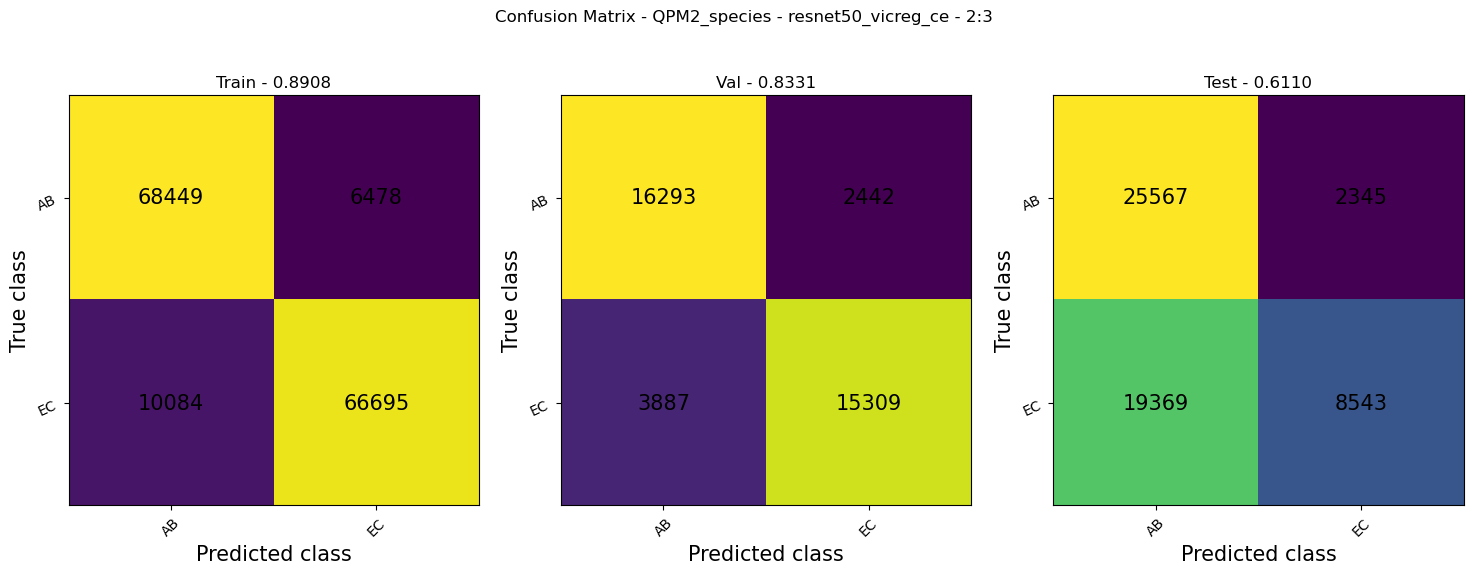

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)
(55824, 2) (41868, 2)


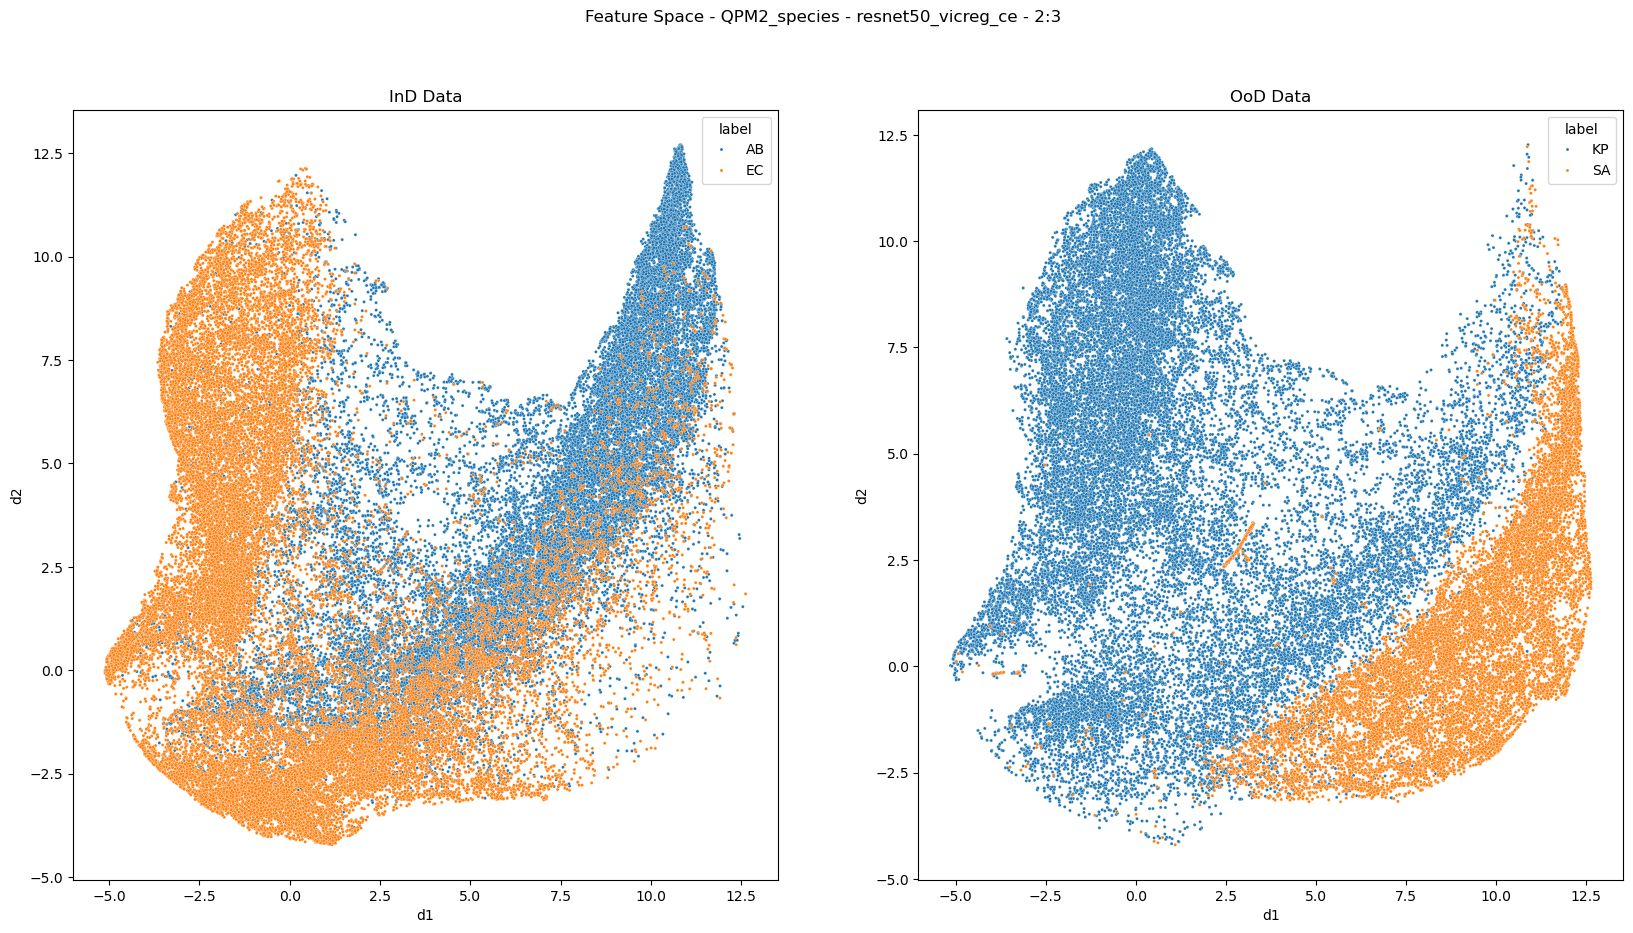

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

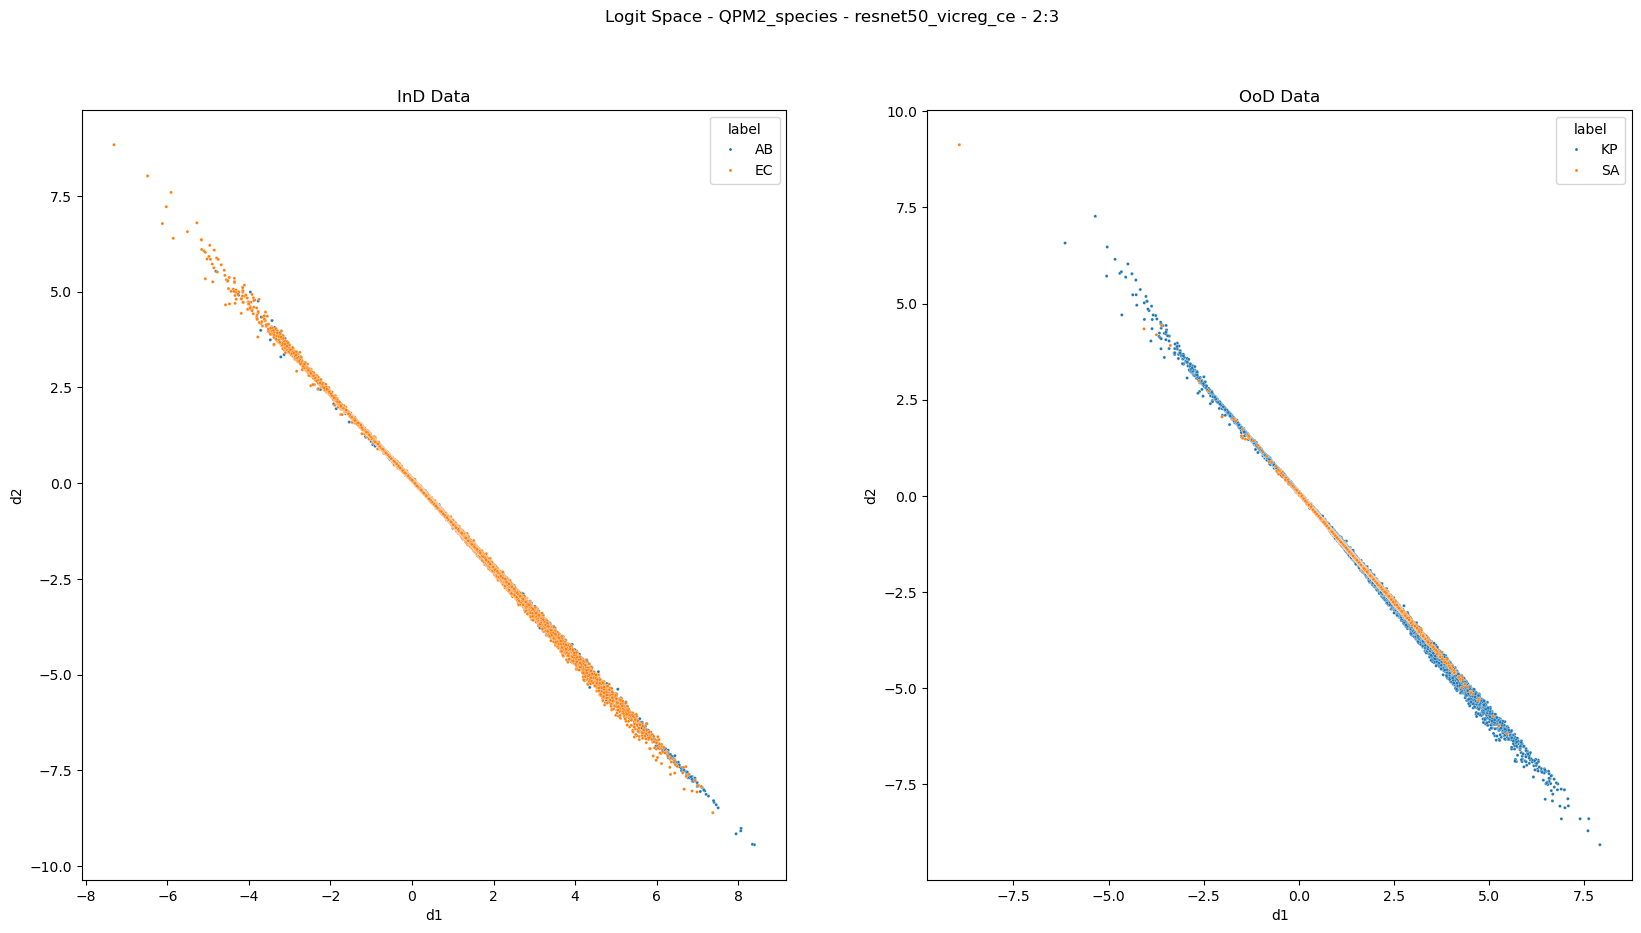

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

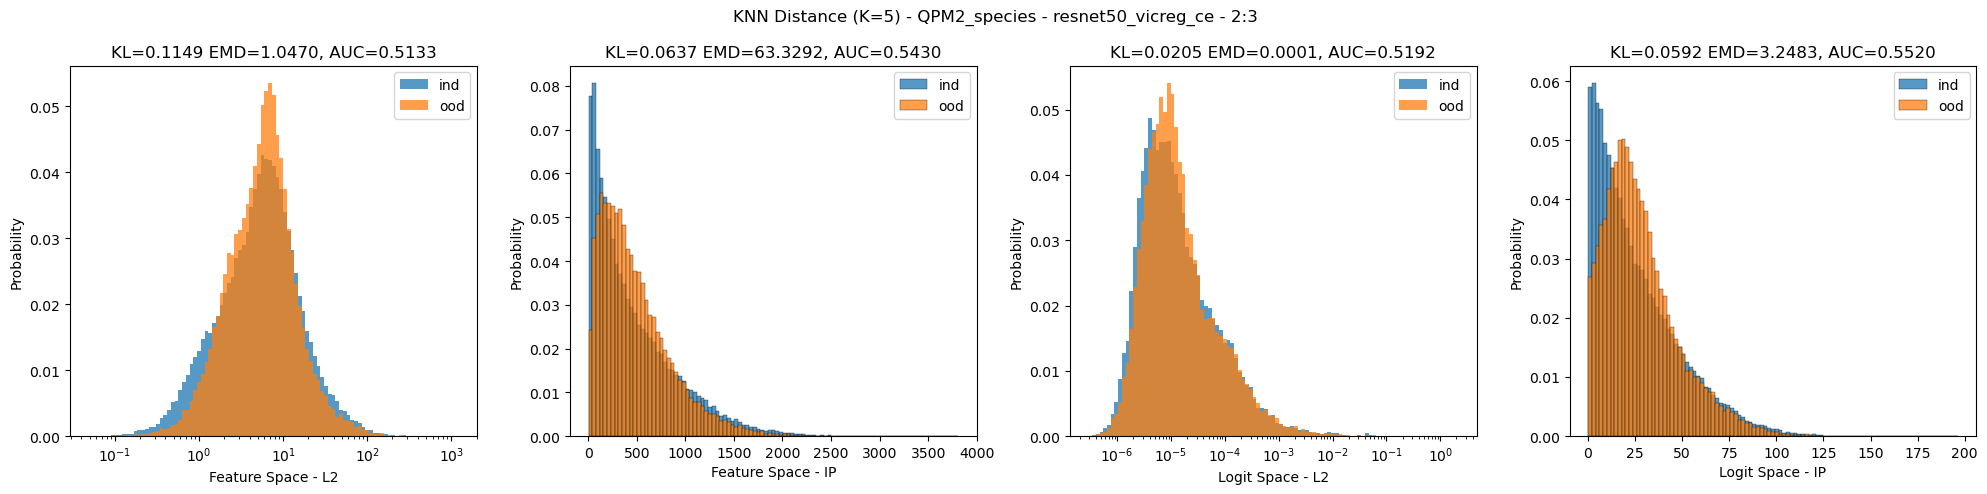

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

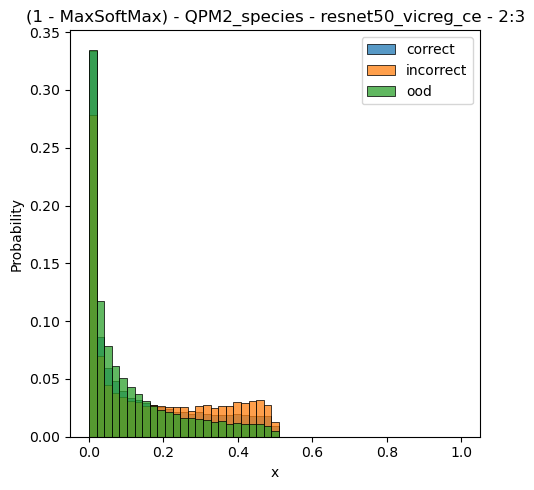

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)